# 土地覆盖分类

kaggle项目请参考：

https://www.kaggle.com/competitions/prors-hw

实践目标

本次遥感模式识别课程实践的任务是实现中国地区土地覆盖分类，课程将提供数据集与代码的模版。
首先请了解机器学习模型在处理分类任务时的基本逻辑与代码结构，然后再利用课堂所学知识，通过修改数据组织方式、模型结构、训练策略等方式来构建自己的模型，在训练集上训练模型，并且在提供的测试集上进行评分，你的目的是尽可能高的提高系统评分。 

实践数据

我们将提供共三个文件，分别是训练数据集、测试数据集、分类结果的模版，详情请参考Data栏目。
训练数据集包含输入特征与分类结果。 而测试数据集仅仅包含输入特征，请利用自己的模型在测试数据集上得到分类结果，注意分类结果格式应与提供的模版一致。

实践方式

请依据课程的代码模版完成模型构建与预测，并将预测的分类结果提交到Kaggle。
课程提供了各类模型的基础代码与注解，可直接在Kaggle中编辑、调试、运行，详情请参考Code栏目。

实践作业
实践作业以报告的形式提交，字数不限， 言简意赅、逻辑清晰即可。**实践成绩与实践中测试集得分无关，而与实践参与情况，实践报告相关**。

下面给出报告格式示例，你也可以自由发挥: 

1.引言 

简述对课程分类问题的认识。

2.数据

介绍数据与数据处理情况，包括对数据进行了哪些预处理，标准化，划分情况。

3.方法

介绍所采用的方法，包含通过课内外的学习，对模型所做出的持续改进，反映出你在实践中的思考过程。

4.实验结果

展示实验结果，并予以讨论和分析，例如精度提升或停滞可能的原因。

5.总结

总结全文 

参与实践的方法请参考概述1.5节




## 数据集的构建（选学）

### 数据源 (选学)
本次数据集制作所用到的遥感产品参照了 MODIS MCD12Q1 Land Cover Type 产品的制作过程（参见[Algorithm Theoretical Basis Document](https://lpdaac.usgs.gov/documents/86/MCD12_ATBD.pdf)），选取了以下遥感产品。
- [Land Cover Type](https://lpdaac.usgs.gov/products/mcd12q1v006/)
- [Land Water Mask](https://lpdaac.usgs.gov/products/mod44wv006/)
- [Nadir BRDF-adjusted Reflectances](https://lpdaac.usgs.gov/products/mcd43a4v061/)
- [Directional Reflectance Information](https://lpdaac.usgs.gov/products/mcd43a1v061/)
- [EVI](https://lpdaac.usgs.gov/products/mod13a2v006/)
- [Snow cover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD10A1)
- [Land Surface Temperature](https://lpdaac.usgs.gov/products/mod11a2v006/)

上述遥感产品均可在GEE上获取，可通过GEEMAP下载数据并预处理，代码如下所示：
https://developers.google.com/earth-engine/datasets/catalog

In [ ]:
! pip -q install geemap geedim 

import os
import ee
import time
from datetime import datetime
import geemap,geedim
from geemap.datasets import DATA
import geemap.foliumap
Map = geemap.Map()

roiChina = ee.Geometry.Rectangle([70, 0, 140, 55])
Map.centerObject(roiChina, 4)
Map.addLayer(roiChina, {}, 'China')
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MCD12Q1"))  # 选定数据集
for name in ['LC_Type1']: # 需要获取的波段名称
    cf = data_collection.filterDate('2019-1-1','2019-12-31').select(name).mean() #选取时间段，并求均值
    geemap.download_ee_image(cf,'/content/drive/Shareddrives/cf/RF/LUC/'+name+'.tif', #保存路径
                           region=roiChina, #选取下载区域
                           crs='EPSG:4326', #选取坐标系
                           scale=1000) #重采用尺度

遥感产品清单

用于替换代码中下载数据集所需的信息
```
Land Cover Type  # 产品名称
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MCD12Q1"))  # 选定数据集
LC_Type1 # 需要获取的波段名称

Land Water Mask 
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/006/MOD44W"))
water_mask

Nadir BRDF-adjusted Reflectances
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MCD43A4"))
Nadir_Reflectance_Band1
Nadir_Reflectance_Band2
Nadir_Reflectance_Band3
Nadir_Reflectance_Band4
Nadir_Reflectance_Band5
Nadir_Reflectance_Band6
Nadir_Reflectance_Band7

Directional Reflectance Information
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MCD43A1"))
BRDF_Albedo_Parameters_vis_iso
BRDF_Albedo_Parameters_vis_vol
BRDF_Albedo_Parameters_vis_geo
BRDF_Albedo_Parameters_nir_iso
BRDF_Albedo_Parameters_nir_vol
BRDF_Albedo_Parameters_nir_geo
BRDF_Albedo_Parameters_shortwave_iso
BRDF_Albedo_Parameters_shortwave_vol
BRDF_Albedo_Parameters_shortwave_geo

EVI
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MOD13A2"))
EVI

Snow Cover
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/006/MOD10A1"))
NDSI_Snow_Cover

Land Surface Temperature
data_collection = ee.ImageCollection(ee.ImageCollection("MODIS/061/MOD11A2"))
LST_Day_1km
```

### 制作数据集（选学）
依据经纬度，依次将下载的遥感影像插值进数据集

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=40,use_memory_fs=False)

df = pd.read_feather('china.feather')

Feature_list = ['EVI','LST','LWM','SC','LUC']

AP_list = [
    'BRDF_Albedo_Parameters_vis_iso',
    'BRDF_Albedo_Parameters_vis_vol',
    'BRDF_Albedo_Parameters_vis_geo',
    'BRDF_Albedo_Parameters_nir_iso',
    'BRDF_Albedo_Parameters_nir_vol',
    'BRDF_Albedo_Parameters_nir_geo',
    'BRDF_Albedo_Parameters_shortwave_iso',
    'BRDF_Albedo_Parameters_shortwave_vol',
    'BRDF_Albedo_Parameters_shortwave_geo'
]

BRDF_list = [
    'Nadir_Reflectance_Band1',
    'Nadir_Reflectance_Band2',
    'Nadir_Reflectance_Band3',
    'Nadir_Reflectance_Band4',
    'Nadir_Reflectance_Band5',
    'Nadir_Reflectance_Band6',
    'Nadir_Reflectance_Band7'
]


def insert_era(group,geotrans,features,Feature_list):
    for itx,name in enumerate(Feature_list):
        y = int(round((group['lat']-geotrans[3])/geotrans[5]))
        x = int(round((group['lon']-geotrans[0])/geotrans[1]))
        group[name] = features[itx, y, x].item()
    return group 

geotrans = (
69.99672693859311,
0.008983152841195215,
0.0,
60.16915773032555,
0.0,
-0.008983152841195215
)

# 此插值针对Feature_list, AP_list, BRDF_list 都要进行一遍
features = []
for name in Feature_list:
    ds = gdal.Open('/content/drive/Shareddrives/cf/RF/'+name+'/'+name+'.tif')
    img = ds.ReadAsArray()
    geotrans = ds.GetGeoTransform()
    features.append(img)
features = np.stack(features)

dff=df.parallel_apply(
    insert_era,axis=1,
    args=(geotrans,
          features,
          Feature_list
            )
)
dff.to_feather('china.feather')

### 数据集划分（选学）
- sklearn.model_selection.train_test_split

train_test_split函数用于将矩阵随机划分为训练子集和测试子集
- sklearn.model_selection.StratifiedKFold

StratifiedKFold它会根据数据集的分布来划分，使得划分后的数据集的目标比例和原始数据集近似，也就是构造训练集和测试集分布相同的交叉验证集。
- sklearn.model_selection.GroupKFold

GroupKFold保证了同一组的样本会被同时划分为训练集或者验证集，而不是既有样本在训练集也有样本在验证集。

更多数据集划分，参见https://scikit-learn.org/stable/modules/classes.html#splitter-classes

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

### 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/df.feather')
df = df.drop(columns=['date','lon','lat'])
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

### 分类常见的评价指标（选学）
- accuracy_score

 分类准确率分数是指所有分类正确的百分比。分类准确率这一衡量分类器的标准比较容易理解，但是它不能告诉你响应值的潜在分布，并且它也不能告诉你分类器犯错的类型。

 ` sklearn.metrics.accuracy_score(y_true, y_pred, normalize=True, sample_weight=None)` 

- confusion_matrix
 
 混淆矩阵的每一列代表了预测类别，每一列的总数表示预测为该类别的数据的数目；每一行代表了数据的真实归属类别，每一行的数据总数表示该类别的数据实例的数目；每一列中的数值表示真实数据被预测为该类的数目。
    
 `sklearn.metrics.confusion_matrix(y_true, y_pred, *, labels=None, sample_weight=None, normalize=None)`

更多分类损失，参见https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics

## 模型选取

### 模型选取:  决策树

原理介绍与可视化

https://mlu-explain.github.io/decision-tree/


模型代码

本次模型由scikit-learn中的[sklearn.tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)实现，部分参数设置如下：

```
sklearn.ensemble.DecisionTreeClassifier(
max_depth = 100,
max_leaf_nodes = 100,
max_features = 'sqrt'
)
```


In [ ]:
import pandas as pd
import numpy as np
from joblib import dump, load

# 决策树模型
from sklearn.tree import DecisionTreeClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

In [ ]:
# 初始化模型
dt_cla = DecisionTreeClassifier(
            max_depth = 100,
            max_leaf_nodes = 100,
            max_features = 'sqrt'
          )

In [ ]:
# 拟合数据集
dt_cla_fit=dt_cla.fit(X_train,y_train)

In [ ]:
# 精度测试
accuracy_score(dt_cla_fit.predict(X_test),y_test)

In [ ]:
# 载入测试集进行预测
X_pre = pd.read_feather('/kaggle/input/prors-hw/test_set.feather')
# 保存预测结果，用于后续制图
X_pre['pre']=dt_cla_fit.predict(X_pre)
# 预测结果需命名为“submission.csv”
X_pre['pre'].astype(np.float32).astype(np.int64).reset_index().to_csv('submission.csv', index=None)

In [ ]:
# 保存模型
dump(dt_cla_fit,'dt_cla_fit.m')

### 模型选取:  随机森林

原理介绍与可视化

https://mlu-explain.github.io/random-forest/


模型代码

本次模型由scikit-learn中的[sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)实现，部分参数设置如下：

```
sklearn.ensemble.RandomForestClassifier(
n_estimators = 100, # 弱分类器个数
criterion = 'gini', # 分割评价标准
max_depth = None, # 单个决策树最大深度
max_features = 'sqrt', # 随机抽取特征的个数
n_jobs = -1, # 并行构建树的个数
verbose = 0, # 是否打印出损失下降过程
)
```

In [ ]:
# ! pip install -q scikit-learn 

import pandas as pd
import numpy as np
from joblib import dump, load

# 随机森林模型
from sklearn.ensemble import RandomForestClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

In [ ]:
# 初始化模型
rf_cla = RandomForestClassifier(
            n_estimators=300,
            n_jobs=-1,
            max_features='sqrt',
            verbose=0,
            max_depth=10,
          )

In [ ]:
# 拟合数据集
rf_cla_fit=rf_cla.fit(X_train,y_train)

In [ ]:
# 精度测试
accuracy_score(rf_cla_fit.predict(X_test),y_test)

In [ ]:
X_test['pre']=rf_cla_fit.predict(X_test)

In [ ]:
# 保存预测结，用于后续制图
df['LUC_pre']=rf_cla.predict(X)

In [ ]:
# 保存模型
dump(rf_cla_fit,'rf_cla_fit.m')

### 模型选取:  梯度提升树

原理介绍与可视化

梯度提升原理与可视化

https://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html

交互式梯度提升树构建

https://arogozhnikov.github.io/2016/07/05/gradient_boosting_playground.html



模型代码

本次模型由scikit-learn中的[sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn-ensemble-gradientboostingclassifier)实现，具体参数设置如下：

```
sklearn.ensemble.GradientBoostingClassifier((
subsample = 0.66,
n_estimators = 100, # 弱分类器个数
learning_rate = 1, # 单个弱分类器的权重
max_depth = True, # 是否启用cuda
max_features = 'sqrt'
)
```


In [ ]:
import pandas as pd
import numpy as np
from joblib import dump, load

# 梯度提升树模型
from sklearn.ensemble import GradientBoostingClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

In [ ]:
# 初始化模型
gb_cla = GradientBoostingClassifier(
            n_estimators=300,
            max_features='sqrt',
            verbose=0,
            max_depth=10,
          )

In [ ]:
# 拟合数据集
gb_cla_fit=gb_cla.fit(X_train,y_train)

In [ ]:
# 精度测试
accuracy_score(gb_cla_fit.predict(X_test),y_test)

### 模型选取:  端到端梯度提升算法

原理介绍

端到端梯度提升网络

[GeoBoost: An Incremental Deep Learning Approach toward Global Mapping of Buildings from VHR Remote Sensing Images](https://doi.org/10.3390/rs12111794)

[Geographical and temporal encoding for improving the estimation of PM2. 5 concentrations in China using end-to-end gradient boosting](https://doi.org/10.1016/j.rse.2021.112828)


模型代码

本次模型由[Ensemble PyTorch](https://ensemble-pytorch.readthedocs.io/en/latest/)中的[torchensemble.gradient_boosting.GradientBoostingClassifier](https://ensemble-pytorch.readthedocs.io/en/latest/parameters.html#gradientboostingclassifier)实现，具体参数设置如下：

```
torchensemble.gradient_boosting.GradientBoostingClassifier((
estimator = estimator, # 自定义弱分类器
n_estimators = 100, # 弱分类器个数
shrinkage_rate = 1, # 单个弱分类器的权重
cuda = True, # 是否启用cuda
)
```


In [ ]:
!pip install torchensemble 

import torch
import pandas as pd
import torch.nn as nn
from torch.nn import functional as F

# 构建单个弱分类器
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(23, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 128)
        self.linear6 = nn.Linear(128, 17)

    def forward(self, data):
        output = F.relu(self.linear1(data))
        output = F.relu(self.linear2(output))
        output = F.relu(self.linear3(output))
        output = F.relu(self.linear4(output))
        output = F.relu(self.linear5(output))
        output = self.linear6(output)
        return output

In [ ]:
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
# 选取标准化方法
from sklearn.preprocessing import normalize
from sklearn.preprocessing import QuantileTransformer

# 构建pytorch可用的数据集
class LUC_dataset(Dataset):
    
    def __init__(self,stage):
        # 读取并划分数据集
        df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
        df = df.dropna()
        df['LUC'] = df['LUC'] - 1 # 减掉1，因为pytorch的index从0开始
        X = df.drop(columns=['LUC'])
        X = normalize(X,axis=1)
        y = df['LUC']

        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y,
                                                            train_size=0.7,
                                                            random_state=0)
        if stage == 'train':
            self.X = torch.from_numpy(X_train).float()
            self.y = torch.from_numpy(y_train.to_numpy()).long()
        elif stage == 'test':
            self.X = torch.from_numpy(X_test).float()
            self.y = torch.from_numpy(y_test.to_numpy()).long()
        elif stage == 'pre':
            self.X = torch.from_numpy(X).float()
            self.y = torch.from_numpy(y.to_numpy()).long()
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx,:], self.y[idx]
    
    def norm(self,X):
        transformer=QuantileTransformer(
        subsample=1000000,
        random_state=0, 
        n_quantiles=100000
        )
        X = transformer.fit_transform(X)
        return X

In [ ]:
# 构建取用数据的迭代器
train_dataloader = DataLoader(
                        LUC_dataset('train'), 
                        batch_size=50000, # 单次更新所用样本个数，减少可降低内存使用
                        shuffle=True,    # 是否打乱数据集内样本顺序
                        num_workers=80, # 由多少个workers从数据集中搬运样本
                        pin_memory=True,
                        )

test_dataloader = DataLoader(
                        LUC_dataset('test'), 
                        batch_size=50000, 
                        shuffle=True, 
                        num_workers=20,
                        pin_memory=True,
                        )

In [ ]:
from torchensemble import GradientBoostingClassifier
from torchensemble import BaggingClassifier

# 设置日志记录
from torchensemble.utils.logging import set_logger
logger = set_logger('classification_luc_mlp')

# 设置模型
model = GradientBoostingClassifier(
    estimator = MLP,
    n_estimators = 30,
    cuda = True,
)

# 设置优化器
model.set_optimizer(
    'Adam', # 选取优化算法
    lr=0.003, # 选取学习率 
    weight_decay=0 # 选取权重衰减率
)

# 设置损失函数
criterion = nn.CrossEntropyLoss()
model.set_criterion(criterion)

In [ ]:
model.fit(train_loader = train_dataloader, 
          save_model = True,
          use_reduction_sum = False,
          early_stopping_rounds = 10,
          test_loader = test_dataloader,
          epochs = 10)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(torch.argmax(model.predict(LUC_dataset('test').X),axis=1),LUC_dataset('test').y)

In [ ]:
df['LUC_pre'] = torch.argmax(model.predict(LUC_dataset('pre').X),axis=1) + 1

In [ ]:
# 载入保存好的模型
from torchensemble.utils import io
from torchensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(
    estimator = MLP,
    n_estimators = 30,
    cuda = False,
)
io.load(model, '/shz/RF/') 

### 模型选取:  XGBoost

原理介绍

[XGBoost: A Scalable Tree Boosting System](https://dl.acm.org/doi/pdf/10.1145/2939672.2939785)

模型代码

本次模型由XGBoost实现中的[xgboost.XGBClassifier](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)实现，部分参数设置如下：

```
XGBClassifier(
    n_estimators = 100,
    max_depth = 10,
    learning_rate = 0.1,
    max_leaves = 31,
    n_jobs = -1
)
```

In [24]:
! pip install xgboost

import pandas as pd
import numpy as np
from joblib import dump, load

# xgboost模型
from xgboost import XGBClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder


In [25]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(float).apply(int)
X = df.drop(columns=['LUC'])
y = df['LUC']

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

In [ ]:
xgb = XGBClassifier(
    n_estimators = 100,
    max_depth = 10
)

In [ ]:
xgb_cla_fit=xgb.fit(X_train,y_train)

In [ ]:
accuracy_score(xgb_cla_fit.predict(X),y)


### 模型选取:  LightGBM

原理介绍

[Lightgbm: A highly efficient gradient boosting decision tree](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)


模型代码

本次模型由LightGBM实现中的[lightgbm.LGBMClassifier](https://lightgbm.readthedocs.io/en/v3.3.2/pythonapi/lightgbm.LGBMClassifier.html)实现，部分参数设置如下：

```
LGBMClassifier(
    n_estimators = 100,
    num_leaves = 31,
    max_depth = 10,
    learning_rate = 0.1,
    n_jobs = -1
)
```


In [ ]:
! pip install lightgbm

import pandas as pd
import numpy as np
from joblib import dump, load

# lightgbm模型
from lightgbm import LGBMClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

In [ ]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)

In [ ]:
lgm = LGBMClassifier(
    n_estimators = 100,
    max_depth = 10
)

In [ ]:
lgm_cla_fit=lgm.fit(X_train,y_train,eval_set=(X_test,y_test),verbose=0)

In [ ]:
accuracy_score(lgm_cla_fit.predict(X),y)

### 模型选取:  Histogram-Based Gradient Boosting

原理介绍

[Histogram-Based Gradient Boosting](https://scikit-learn.org/stable/modules/ensemble.html#histogram-based-gradient-boosting)


模型代码

本次模型由scikit-learn实现中的[sklearn.ensemble.HistGradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn-ensemble-histgradientboostingclassifier)实现，部分参数设置如下：

```
HistGradientBoostingClassifier(
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = 10,
    learning_rate = 0.1,
)
```

In [ ]:
import pandas as pd
import numpy as np
from joblib import dump, load

# HistGradientBoosting
from sklearn.ensemble import HistGradientBoostingClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
# 读取并划分数据集
df = pd.read_feather('/shz/RF/china.feather')
df = df.drop(columns=['date'])
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)


In [ ]:
# 初始化模型
hgb_cla = HistGradientBoostingClassifier(
    max_iter = 100,
    max_leaf_nodes = 31,
    max_depth = 10,
    learning_rate = 0.1,
)

In [ ]:
# 拟合数据集
hgb_cla_fit=hgb_cla.fit(X_train,y_train)

In [ ]:
# 精度测试
accuracy_score(hgb_cla_fit.predict(X_test),y_test)

## 分类结果可视化

In [22]:
import pandas as pd
import numpy as np
from joblib import dump, load

# 决策树模型
from sklearn.tree import DecisionTreeClassifier

# 评价指标
from sklearn.metrics import accuracy_score

# 训练，验证，测试集划分方式
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# 可视化
from matplotlib.colors import ListedColormap

In [4]:
# 初始化模型
dt_cla = DecisionTreeClassifier(
            max_depth = 100,
            max_leaf_nodes = 100,
            max_features = 'sqrt'
          )

In [5]:
# 读取并划分数据集
df = pd.read_feather('/kaggle/input/prors-hw/training_set.feather')
df = df.dropna()
df['LUC']=df['LUC'].apply(str)
X = df.drop(columns=['LUC'])
y = df['LUC']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.5,
                                                    random_state=0)
# 拟合数据集
dt_cla_fit=dt_cla.fit(X_train,y_train)

In [15]:
# 载入测试集进行预测
df = pd.read_feather('/kaggle/input/prors-hw/Visualization.feather')
df = df.drop(columns=['date'])
df= df.dropna()
# 保存预测结果，用于后续制图

In [19]:
df['LUC_pre']=dt_cla_fit.predict(df[X_train.columns])

In [17]:
# 初始化空矩阵进行赋值
true = np.zeros([4000, 7000]) * np.nan
pre = np.zeros([4000, 7000]) * np.nan
# 根据经纬度计算影像的坐标值
geotrans = tuple(np.array([70, 0.01, 0, 55, 0, -0.01]))
df['tif_x'] = round((df['lat']-geotrans[3])/geotrans[5]).astype(int)
df['tif_y'] = round((df['lon']-geotrans[0])/geotrans[1]).astype(int)

In [20]:
# 赋值给空矩阵
for row in df.itertuples():
    true[int(getattr(row, 'tif_x')), int(getattr(row, 'tif_y'))] = getattr(row, 'LUC')
    pre[int(getattr(row, 'tif_x')), int(getattr(row, 'tif_y'))] = getattr(row, 'LUC_pre')

In [23]:
labels = [
    'Evergreen Needleleaf forest',
    'Evergreen Broadleaf forest',
    'Deciduous Needleleaf forest',
    'Deciduous Broadleaf forest',
    'Mixed forest',
    'Closed shrublands',
    'Open shrublands',
    'Woody savannas',
    'Savannas',
    'Grasslands',
    'Permanent wetlands',
    'Croplands',
    'Urban and built-up',
    'Cropland/Natural vegetation mosaic',
    'Snow and ice',
    'Barren or sparsely vegetated',
    'Water',
]
cmap = ListedColormap([
    '#05450a',
    '#086a10',
    '#54a708',
    '#78d203',
    '#009900',
    '#c6b044',
    '#dcd159',
    '#dade48',
    '#fbff13',
    '#b6ff05',
    '#27ff87',
    '#c24f44',
    '#a5a5a5',
    '#ff6d4c',
    '#69fff8',
    '#f9ffa4',
    '#1c0dff',
])

**分类结果代号、颜色、含义**
```
1	05450a	Evergreen Needleleaf Forests: dominated by evergreen conifer trees (canopy >2m). Tree cover >60%.

2	086a10	Evergreen Broadleaf Forests: dominated by evergreen broadleaf and palmate trees (canopy >2m). Tree cover >60%.

3	54a708	Deciduous Needleleaf Forests: dominated by deciduous needleleaf (larch) trees (canopy >2m). Tree cover >60%.

4	78d203	Deciduous Broadleaf Forests: dominated by deciduous broadleaf trees (canopy >2m). Tree cover >60%.

5	009900	Mixed Forests: dominated by neither deciduous nor evergreen (40-60% of each) tree type (canopy >2m). Tree cover >60%.

6	c6b044	Closed Shrublands: dominated by woody perennials (1-2m height) >60% cover.

7	dcd159	Open Shrublands: dominated by woody perennials (1-2m height) 10-60% cover.

8	dade48	Woody Savannas: tree cover 30-60% (canopy >2m).

9	fbff13	Savannas: tree cover 10-30% (canopy >2m).

10	b6ff05	Grasslands: dominated by herbaceous annuals (<2m).

11	27ff87	Permanent Wetlands: permanently inundated lands with 30-60% water cover and >10% vegetated cover.

12	c24f44	Croplands: at least 60% of area is cultivated cropland.

13	a5a5a5	Urban and Built-up Lands: at least 30% impervious surface area including building materials, asphalt and vehicles.

14	ff6d4c	Cropland/Natural Vegetation Mosaics: mosaics of small-scale cultivation 40-60% with natural tree, shrub, or herbaceous vegetation.

15	69fff8	Permanent Snow and Ice: at least 60% of area is covered by snow and ice for at least 10 months of the year.

16	f9ffa4	Barren: at least 60% of area is non-vegetated barren (sand, rock, soil) areas with less than 10% vegetation.

17	1c0dff	Water Bodies: at least 60% of area is covered by permanent water bodies.
```

(-0.5, 6999.5, 3999.5, -0.5)

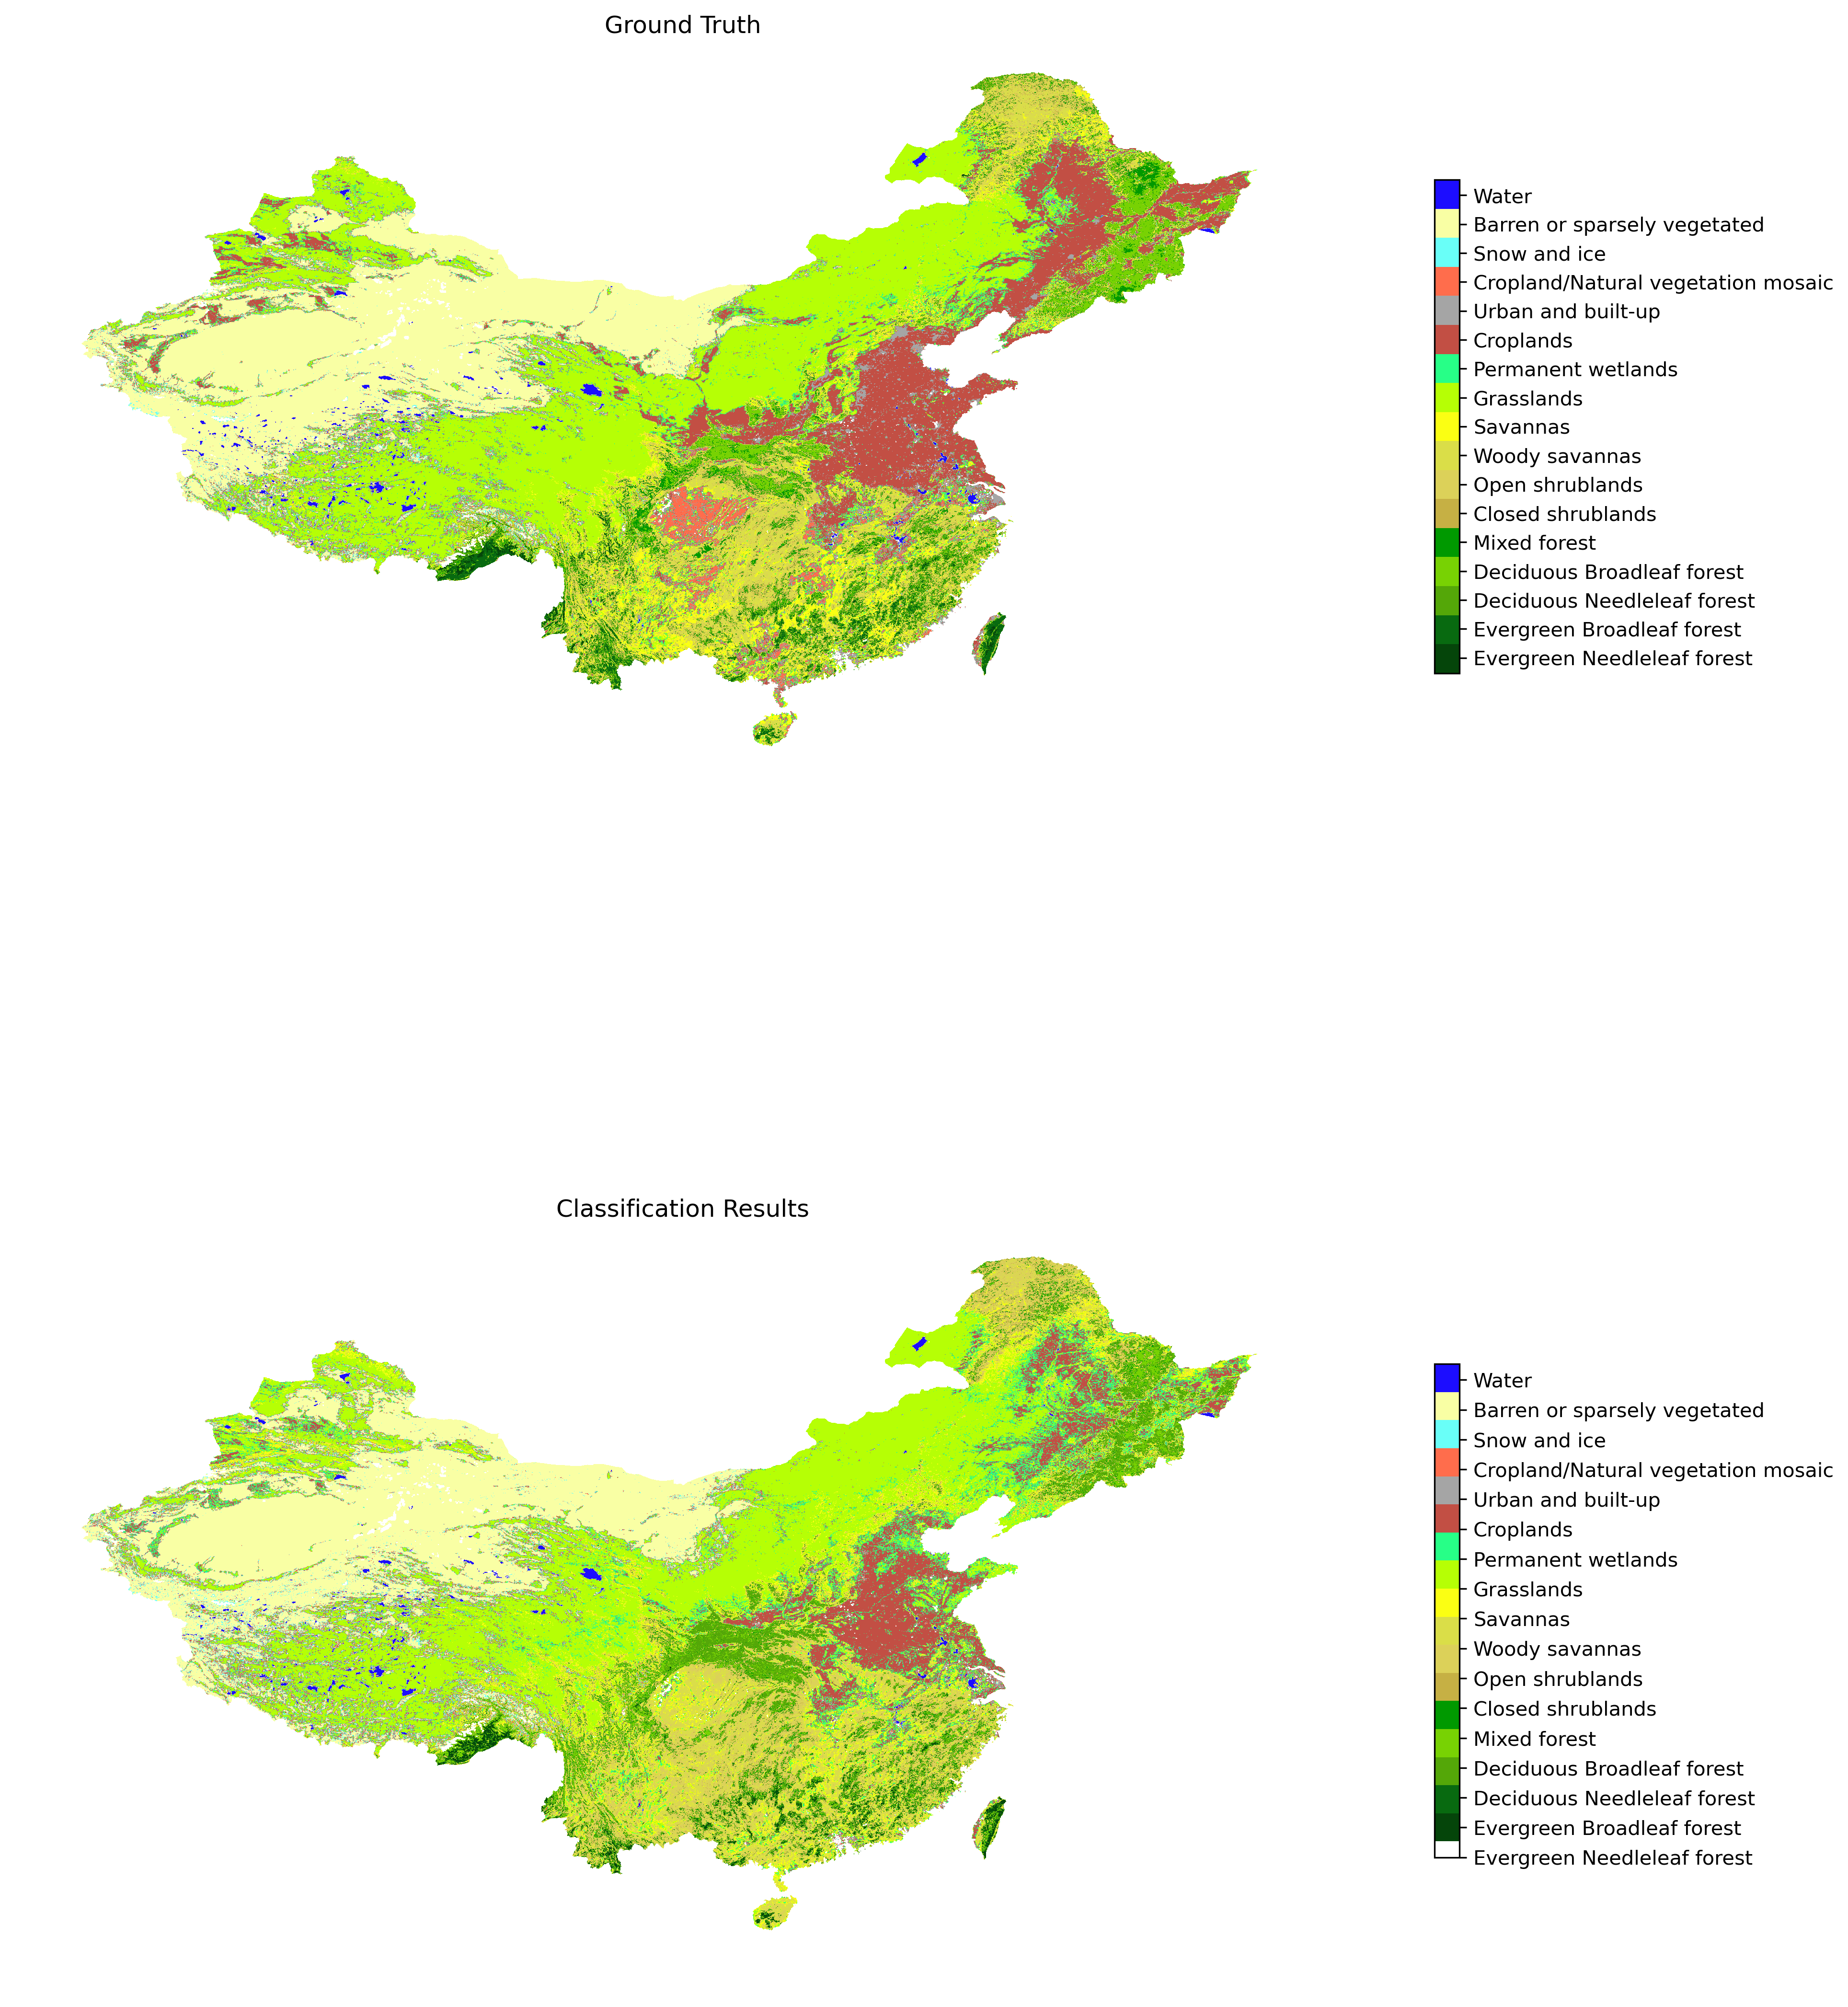

In [32]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

fig,ax = plt.subplots(2,1,dpi=300)
fig.set_figheight(20)
fig.set_figwidth(15)

cp = ax[0].imshow(true,cmap=cmap)
cb = plt.colorbar(cp,ax=ax[0],shrink=0.5)
cb.set_ticks(np.linspace(1.5, 16.5, 17))
cb.set_ticklabels(labels)
ax[0].axis('off')
ax[0].set_title('Ground Truth')

# 如果预测结果的colorbar出现了空白，说明预测结果中缺少了一个类别
cp2 = ax[1].imshow(pre,cmap=cmap)
ax[1].set_title('Classification Results')
cb = plt.colorbar(cp2,ax=ax[1],shrink=0.5)
cb.set_ticks(np.linspace(1.5, 16.5, 17))
cb.set_ticklabels(labels)
ax[1].axis('off')